# Sprint 2: Unsupervised learning

Tijdens deze tweede sprint wordt gefocust op het clusteren van de data. Aan de hand van de verschillende klachtbeschrijvingen trachten we de verschillende categorieën voor de producten en issues te voorspellen zonder de categorieën opvoorhand te specifiëren (unsupervised learning). Op die manier trachten we de klachten op een betere manier te groeperen in vergelijking met de reeds gedefinieërde categorieën in de dataset.

We zullen in deze sprint met meerdere technieken gaan experimenteren en telkens de onderlinge resultaten gaan vergelijken.

1. K-means clustering
2. DBScan clustering
3. Topic modeling: LDA (Latent Dirichlet Allocation)

Voor elke techniek gaan we de data pre-processing en feature extraction apart behandelen aangezien de resultaten van de verschillende technieken hiervan sterk afhankelijk zijn.

## Inlezen dataset

De data exploratie wordt hier beperkt tot enkel het inlezen van de vereiste data. Dit werd reeds tijdens sprint 1 uitvoerig behandeld.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rows_to_read = None # Gewenst aantal rijen inlezen (None = allemaal)

complaints_df = pd.read_csv('../data/complaints.csv', delimiter=',', nrows=rows_to_read)
complaints_df = complaints_df[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


In [33]:
product_count = len(complaints_df.Product.unique())
print('Aantal product categorieën:', product_count)

Aantal product categorieën: 18


## 3. Topic modeling: Latent Dirichlet Allocation

Topic modeling wordt gebruikt om tekst uit een document te classificeren onder een specifiek onderwerp. Per document wordt een 'topic' bepaald, en per 'topic' worden de woorden bepaald die tot dit onderwerp behoren. LDA neemt aan dat elk document bestaat uit woorden die op een of andere manier gerelateerd zijn aan elkaar, en probeert deze onderliggende verbanden te zoeken.

### Data pre-processing

Tijdens de vorige sprint hebben we gezien dat de dataset zeer ongebalanceerd is. Tijdens uitvoering van het experiment wordt al snel duidelijk dat het onpraktisch wordt om met deze ongebalanceerde dataset te gaan clusteren omwille van de vereiste resources, alsook de zeer grote verschillen tussen de grootste en kleine categorieën. Hierbij wordt data weggelaten uit de categorieën die het meest voorkomen (undersampling). Net zoals tijdens de vorige sprint nemen we enkele sterk gerelateerde product categorieën hier opnieuw samen.

In [34]:
complaints_df.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [35]:
product_count = len(complaints_df.Product.unique())
print('Aantal product categorieën:', product_count)

Aantal product categorieën: 13


<Figure size 720x360 with 0 Axes>

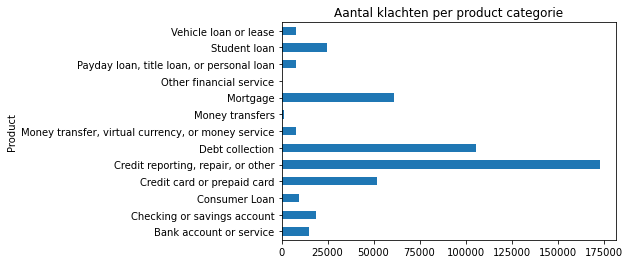

In [36]:
product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per product categorie", legend=None)

In [37]:
def sampling_k_elements(category, k=10000):
    if len(category) < k:
        return category
    return category.sample(k)

balanced_df = complaints_df.groupby('Product').apply(sampling_k_elements).reset_index(drop=True)

<Figure size 720x360 with 0 Axes>

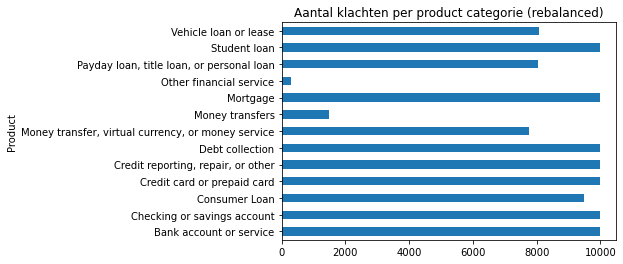

In [38]:
balanced_counts = pd.DataFrame({'Count': balanced_df.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
balanced_counts.plot.barh(title="Aantal klachten per product categorie (rebalanced)", legend=None)

In [39]:
balanced_counts

,Count
Product,
Bank account or service,10000
Checking or savings account,10000
Consumer Loan,9473
Credit card or prepaid card,10000
"Credit reporting, repair, or other",10000
Debt collection,10000
"Money transfer, virtual currency, or money service",7751
Money transfers,1497
Mortgage,10000


Klachten worden gefilterd aan de hand van de volgende voorwaarden:
- **tokenization**: tekst wordt opgesplitst in een sequentie van woorden zonder punctuatie en alles in lower case
- woorden met **minder dan 3 karakters** worden weggelaten
- **stopwoorden** worden verwijderd
- **werkwoorden in derde persoon** worden veranderd naar de eerste persoon
- **werkwoorden in verleden tijd** worden veranderd naar het heden
- woorden worden gereduceerd tot hun **stamvorm**
- alles wat niet gelijk is aan een lowercase of whitespace eruit filteren, alle getallen eruit filteren, returns en newlines eruithalen, kaartnummers eruit filteren

In [41]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return ' ' . join(result)

In [43]:
%%time

balanced_df['Narrative_Processed'] = balanced_df['Narrative'].apply(processing)

CPU times: user 4min 7s, sys: 1.11 s, total: 4min 8s
Wall time: 4min 8s


In [44]:
balanced_df[['Narrative', 'Narrative_Processed']]

,Narrative,Narrative_Processed
0,on XXXX/XXXX/2016 I made a deposit of {$400.00...,deposit time account draw account bring curren...
1,PNC bank came to my place of work and recruite...,bank come place work recruit open check accoun...
2,After 10+ years of banking at Wells Fargo they...,year bank well fargo close account busi decis ...
3,I have a Health Savings Account ( HSA ) with a...,health save account local bank earli year bank...
4,I went into TD Bank on XX/XX/2017 to make a de...,go bank make deposit hand teller check endors ...
...,...,...
105138,I bought a new XXXX XXXX XXXX from the dealer...,buy dealership sign contract month later borro...
105139,In the past couple months this company allowed...,past coupl month compani allow credit permiss ...
105140,The creditor is unwilling to try to work with ...,creditor unwil work late payment threaten repo...
105141,"After an accident in my leased vehicle, my ins...",accid leas vehicl insur compani valu higher le...


### Bag of words (BoW)

Om de LDA analyse te starten, moeten we de tekstuele data omvormen naar een simpele vector representatie die voor elke klacht het aantal keer een woord voorkomt gaat gaan tellen (Bag of Words).

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(balanced_df['Narrative_Processed'])

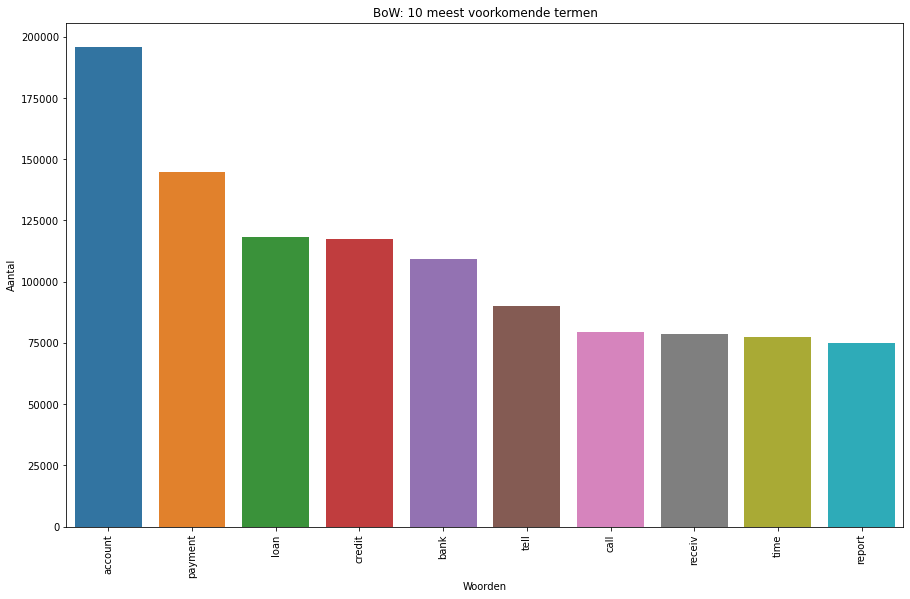

In [46]:
words = count_vectorizer.get_feature_names()
total_counts = np.zeros(len(words))
for t in bag_of_words:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='BoW: 10 meest voorkomende termen')
sns.barplot(x_pos, counts)
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Woorden')
plt.ylabel('Aantal')
plt.show()

### LDA model training

In [47]:
%%time

import os
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=product_count, n_jobs=os.cpu_count())
lda.fit(bag_of_words)

CPU times: user 19.6 s, sys: 6.75 s, total: 26.3 s
Wall time: 3min 14s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=32,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Topics gevonden met LDA:

Topic #0:
account receiv email bank money send chase transfer inform call number contact tell paypal transact claim phone say custom servic request time fund provid refund state ask issu depart speak disput day case wire return respons need fraud file use person address repres confirm hold process help busi complaint cancel


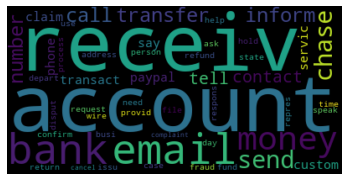


Topic #1:
credit report account inform remov disput file consum inquiri compani ident request verifi theft agenc equifax provid investig letter delet item fraudul bureaus send open number date address document fraud state experian person contact fcra copi author list section creditor inaccur polic proof transunion score result violat bureau victim secur


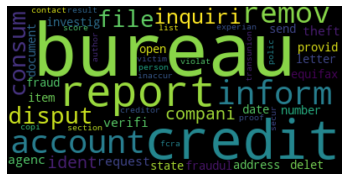


Topic #2:
debt collect letter receiv send request inform provid compani state valid agenc contact document servic claim origin account violat mail write attempt alleg complaint address legal notic copi date contract regard respons creditor proof practic collector credit disput number continu owe file action respond agreement communic certifi offic note recoveri


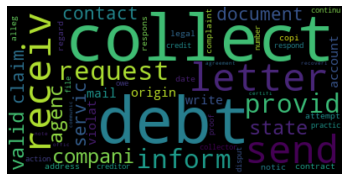


Topic #3:
mortgag home loan properti document modif file state letter request foreclosur receiv servic sale court attorney insur time send date hous year bankruptci bank ocwen provid complaint sell inform compani process case lender requir apprais record submit review claim contact attach note short complet respons legal offic continu close includ


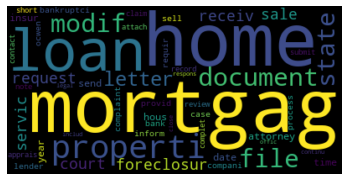


Topic #4:
call tell charg say time phone compani ask speak go work number know just pay want make month tri fee account stop like leav receiv take payment help contact need come explain state manag person harass supervisor peopl talk give repres get year answer today custom money credit dont week


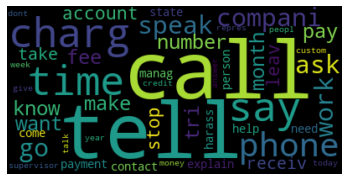


Topic #5:
check bank account well fargo deposit fund overdraft fee money hold cash branch charg return avail busi clear transact custom balanc time withdraw day suntrust issu process post america take go state manag tell releas place make cover caus refus write direct negat chase servic teller pend polici complaint person


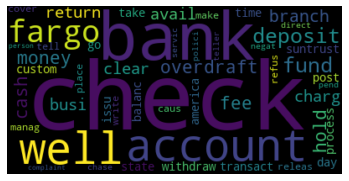


Topic #6:
loan student navient year repay school plan program feder pay incom time forbear payment servic forgiv consolid month educ privat take help make defer colleg qualifi borrow work graduat default tell attend go option univers enrol navi base financi know money nelnet current like start debt abl inform need appli


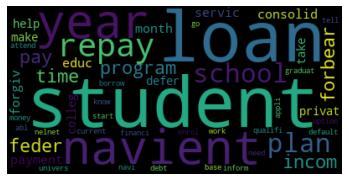


Topic #7:
tell say money send go call check need ask bank time know close want receiv help take just come give week mail work day cash union person tri wait number manag offic home sign letter speak talk inform address didnt mother get like later branch happen problem husband look leav


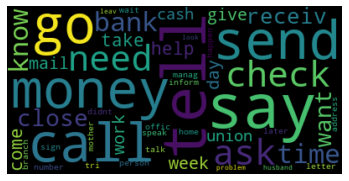


Topic #8:
payment month account pay balanc make loan appli receiv servic statement tell charg date time call princip escrow fee mortgag addit send request onlin custom chang compani late state correct repres inform process automat total issu go check payoff say take increas schedul year extra day show speak websit transfer


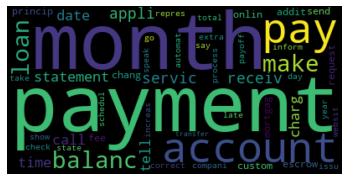


Topic #9:
account card bank open close charg check credit receiv transact debit custom america time use offer citibank citi fraud day coinbas tell onlin deposit access bonus month money promot servic requir inform purchas issu balanc activ withdraw save transfer point usaa fraudul state call secur busi fund year make statement


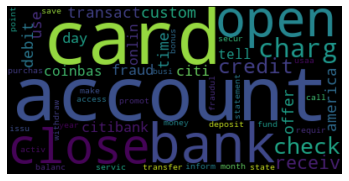


Topic #10:
vehicl financ leas purchas financi contract dealership titl repossess alli insur dealer santand state compani pay auto receiv sell payment credit return sale time sign month contact issu inform consum total price trade servic agreement damag repair send toyota charg drive tell accept truck warranti loan take letter document provid


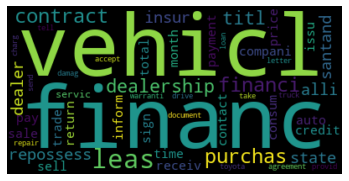


Topic #11:
loan payment month rate time tell pay make year compani work help credit approv go inform appli need offer ask applic lower take refin call want incom tri say financi just lender abl give process know like current term contact high deni receiv option afford state start sign rat feel


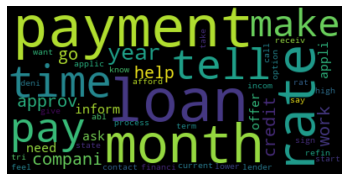


Topic #12:
credit payment report late account pay balanc month time receiv day date statement show correct past score letter remov loan send charg capit year close bank delinqu negat contact inform make bureaus error issu state histori updat compani call auto status disput miss current incorrect chang mail tell card notic


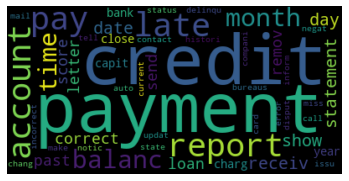

In [55]:
from wordcloud import WordCloud

number_words = 50

print("Topics gevonden met LDA:")
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    top_words = " ".join([words[i] for i in topic.argsort()[:-number_words - 1:-1]])
    print(top_words)
    
    # Genereer WordCloud
    wordcloud = WordCloud().generate(top_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## 2. K-means clustering

## 3. DBScan clustering